Collaborative Filtering
* Item-Item 
* Centered Cosine Similarity
* Top-k

https://www.ethanrosenthal.com/2015/11/02/intro-to-collaborative-filtering/

## Import Data 

In [1]:
%matplotlib inline

import pandas as pd

r = pd.read_csv( 'ratings.csv' )

In [2]:
n_users = r.user_id.unique().shape[0]
n_books = r.book_id.unique().shape[0]
print(str(n_users) + ' users')
print(str(n_books) + ' books')

53424 users
10000 books


## Construct Matrix

In [3]:
import numpy as np

# id starts from 1, but python starts at 0
ratings = np.zeros((n_books, n_users))
for row in r.itertuples():
    ratings[row[2]-1, row[1]-1] = row[3]

In [4]:
def get_sparsity(ratings):
    sparsity = float(len(ratings.nonzero()[0]))
    sparsity /= (ratings.shape[0] * ratings.shape[1])
    sparsity *= 100
    return sparsity

In [5]:
print(f'Sparsity: {get_sparsity(ratings)}%')

Sparsity: 1.118688042827194%


## Only keep top 1000 books

In [6]:
N = 1000
book_index = np.argpartition(np.count_nonzero(ratings, axis=1), -N)[-N:]
print(len(book_index))

1000


In [7]:
ratings = ratings[book_index]

In [8]:
book_stat = np.count_nonzero(ratings, axis=1)
print(f'min:  {book_stat.min()}\nmean: {book_stat.mean()}\nmax:  {book_stat.max()}')

min:  1183
mean: 3179.65
max:  22806


In [9]:
print(f'Sparsity: {get_sparsity(ratings)}%')

Sparsity: 5.951725816112609%


## Only keep top 10000 users

In [10]:
N = 10000
user_index = np.argpartition(np.count_nonzero(ratings, axis=0), -N)[-N:]
print(len(user_index))

10000


In [11]:
ratings = ratings[:, user_index]
ratings.shape

(1000, 10000)

In [12]:
user_stat = np.count_nonzero(ratings, axis=0)
print(f'min:  {user_stat.min()}\nmean: {user_stat.mean()}\nmax:  {user_stat.max()}')

min:  82
mean: 98.3166
max:  177


In [13]:
print(f'Sparsity: {get_sparsity(ratings)}%')

Sparsity: 9.831660000000001%


## Get Train and Test Set

Removing 10 ratings per item from the training set and placing them in the test set.

In [14]:
def train_test_split(ratings):
    test = np.zeros(ratings.shape)
    train = ratings.copy()
    for book in range(ratings.shape[0]):
        test_ratings = np.random.choice(ratings[book, :].nonzero()[0], 
                                        size=20, 
                                        replace=False)
        train[book, test_ratings] = 0
        test[book, test_ratings] = ratings[book, test_ratings]
        
    # Test and training are truly disjoint
    assert(np.all((train * test) == 0)) 
    return train, test

train, test = train_test_split(ratings)

## Center Matrix

In [15]:
train_centered = train.copy()

def center_row(row):
    index = row.nonzero()[0]
    avg = row[index].mean()
    row[index] = row[index] - avg
    return row
    
train_centered = np.apply_along_axis(center_row, 1, train_centered)

## Calculate Similarity Matrix

In [16]:
def similarity(ratings, kind='item'):
    if kind == 'item':
        sim = ratings.dot(ratings.T)
    norms = np.array([np.sqrt(np.diagonal(sim))])
    return (sim / norms / norms.T)

item_similarity = similarity(train_centered, kind='item')

## Calculate MSE Error

In [17]:
from sklearn.metrics import mean_squared_error

def get_mse(pred, actual):
    # Ignore nonzero terms
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return mean_squared_error(pred, actual)

## Calculate Recall, Precision and Coverage

In [33]:
def get_recall_precision_coverage(pred, actual):
    # We only want the part that corresponds to test set in predicted result
    valid_actual = actual.flatten()
    valid_pred = pred.copy().flatten()
    valid_pred[np.where(valid_actual == 0)] = 0
    
    recommend = np.argpartition(valid_pred, -10)[-10:]
    relevant = np.argpartition(valid_actual, -10)[-10:]
    intersect = np.intersect1d(recommend, relevant)
    
    return intersect.size / recommend.size, intersect.size / relevant.size

## Predict Result

In [22]:
def predict(item_similarity, train, K=40):
    pred = np.zeros(train.shape)
    for i in range(train.shape[0]):
        for j in range(train.shape[1]):
            # Already rated by user
            if (train[i][j] != 0):
                pred[i][j] = train[i][j]
                continue
            # Note rated by user
            user_nonzero = np.where(train[:, j] != 0)[0]
            similarity = item_similarity[i][user_nonzero]
            topK = np.argpartition(similarity, -K)[-K:]
            pred[i][j] = np.dot(similarity[topK], train[user_nonzero[topK], j]) / similarity[topK].sum()
    return pred

## Calculate MSE

In [34]:
k_list = [5, 10, 15, 20, 25, 30]
mse = []
recall = []
precision = []
    
for k in k_list:
    pred = predict(item_similarity, train, K=k)
    mse.append(get_mse(pred, test))
    res = get_recall_precision(pred, test)
    recall.append(res[0])
    precision.append(res[1])

print(mse)
print(recall)
print(precision)

[0.7479575844921488, 0.7195876375864656, 0.7149611540831659, 0.7174009245942312, 0.721544348272128, 0.7257612621770392]
[0.8399663971437572, 0.8438823146238194, 0.8485354716560864, 0.8512554892467065, 0.8501761964306014, 0.8498223088387022]
[0.6094011884808777, 0.5921834526893189, 0.5804510132561329, 0.575956117629133, 0.5697851592259637, 0.5647569708974555]


## Plot the Result

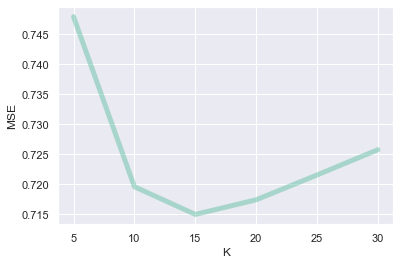

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
pal = sns.color_palette("Set2", 2)
plt.plot(k_list, mse, c=pal[0], alpha=0.5, linewidth=5)
plt.xlabel('K')
plt.ylabel('MSE')
plt.show()

MSE reaches the lowest point when K = 15.

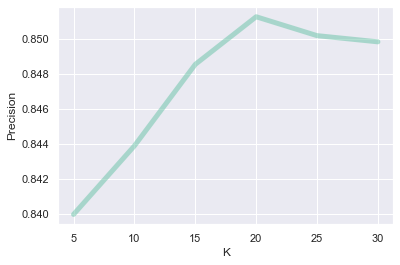

In [36]:
plt.plot(k_list, recall, c=pal[0], alpha=0.5, linewidth=5)
plt.xlabel('K')
plt.ylabel('Precision')
plt.show()

Precision reaches the highest point when K = 20.

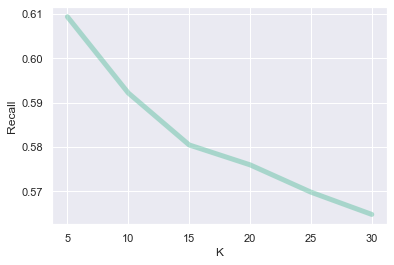

In [37]:
plt.plot(k_list, precision, c=pal[0], alpha=0.5, linewidth=5)
plt.xlabel('K')
plt.ylabel('Recall')
plt.show()

Recall decreases as K increases.

## Save Result to File

In [32]:
np.savez('CF_data.npz', book_index=book_index, user_index=user_index, item_similarity=item_similarity)